Trying to see what is the most optimal number of few shot prompts to use in the agent answer generation.

In [4]:
# create some partials for the agents 

from chat_llm import ReflectingAgent, ChatThread, load_chat
from llm_engines import LLMApi
from functools import partial



In [7]:
john_partial = partial(ReflectingAgent, name="John",llm=LLMApi(), interests=["gossip","f1", "climate change"], behavior=["smart","reflective","funny"], n_last_messages=10, n_last_messages_reflection=20)
mary_partial = partial(ReflectingAgent, name="Mary",llm=LLMApi(), interests=["bouldering", "italian movies", "playing the arp"], behavior=["kind", "creative", "friendly"], n_last_messages=10, n_last_messages_reflection=20)

In [11]:
# a list of number of examples for each agent
import os 

n_examples = [1,2,3,5,10,15,20,25]

for n in n_examples:
    john = john_partial(n_examples=n)
    mary = mary_partial(n_examples=n)
    # run 10 chat per configuration
    for i in range(10):
        chat = ChatThread(agent_list=[john,mary], neutral_llm=LLMApi())
        chat.run_chat(max_turns=75)
        
        try:
            # find latest chat in the chat_logs folder
            latest_chat= max([f for f in os.listdir("chat_logs") if f.startswith("chat")], key=os.path.getctime)
            print(f"Chat {i} with {n} examples saved as ")
        except:
            continue


John: How is it going?
Mary: Hey John, just got back from a fun bouldering session! Any new
    recommendations on Italian movies? I'm in the mood for something light-
    hearted :smile:
John: Hi Mary! I've heard "The Great Beauty" is an excellent choice.
    I've been watching F1 highlights lately, and boy, the drama on the track is
    heating up! Any chance you've developed a new hobby like bouldering or
    something that gets your adrenaline pumping? :muscle:
Mary: That sounds like a great movie recommendation, John! I'll have to
    check it out. In the meantime, I've been trying to get into some light-
    hearted, adventurous movies that have some adrenaline-pumping moments like
    bouldering. Have you ever seen **Cliffhanger** or **Vertical Limit**?
    They're all about mountain climbing, which is kind of similar to bouldering
    in a way. I think you might enjoy them!  Oh, by the way, my friend
    introduced me to an awesome analog instrument the other day - the **arp**,

KeyboardInterrupt: 

In [44]:
import os
import os
from chat_llm import load_chat


# load the last chat


chat_paths= [os.path.join("chat_logs",f) for f in os.listdir("chat_logs") if f.startswith("chat")]
chat_paths.sort(key=os.path.getctime)

# get latest chat
chat_path = chat_paths[-1]

In [74]:
# load chat
chat = load_chat(chat_path)

def plot_evaluation(eval):
    import matplotlib.pyplot as plt
    import numpy as np
    from collections import Counter

    # get the evaluation of the chat
    evaluation = eval
    step_eval=[  ]
    total_eval=[  ]
    
    
    
    for key in evaluation:
        step_eval.append((key,evaluation[key]["step_evaluation"]))
        total_eval.append((key,evaluation[key]["evaluation"]))

    
    # plot the evaluation
    fig, ax = plt.subplots()
    # plot two trend lines over turn count
    ax.plot([x[0] for x in step_eval],[x[1] for x in step_eval], label="Step evaluation")
    ax.plot([x[0] for x in total_eval],[x[1] for x in total_eval], label="Total evaluation")
    
    print("Step evaluation",step_eval)
    print("Total evaluation",total_eval)
    
    ax.legend()
    
    ax.set_xlabel('Turn count')
    ax.set_ylabel('Evaluation')
    ax.set_title('Evaluation of the chat')
    plt.show()

Step evaluation [('10', 9.0), ('20', 8.666666666666666), ('30', 8.333333333333334), ('40', 9.0), ('50', 9.0), ('60', 9.0), ('70', 8.666666666666666), ('77', 8.0)]
Total evaluation [('10', 8.333333333333334), ('20', 9.0), ('30', 8.666666666666666), ('40', 8.0), ('50', 7.666666666666667), ('60', 8.666666666666666), ('70', 8.666666666666666), ('77', 8.666666666666666)]


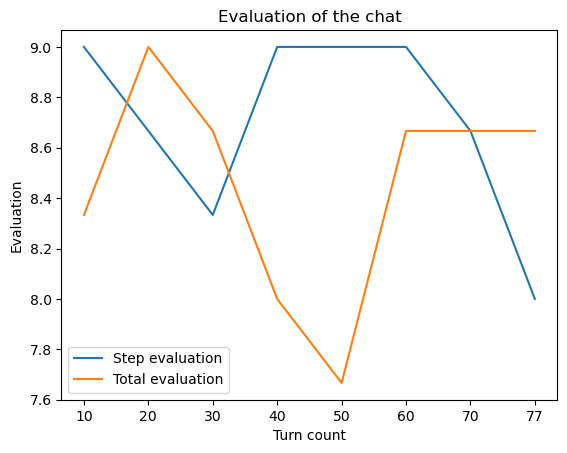

In [75]:
plot_evaluation(chat.chat_evaluation)

In [53]:
# for each chat path, find the n_examples and put the chat eval in a dict

chat_evals = {}
for chat_path in chat_paths:
    try:
        chat = load_chat(chat_path)
    except:
        print(f"Error loading chat {chat_path}")
    n_examples = chat.agent_list[0].n_examples
    try:
        chat_evals[n_examples].append(chat.chat_evaluation)
    except:
        chat_evals[n_examples] = [chat.chat_evaluation]
        


Error loading chat chat_logs/chat_1706903644.json


In [55]:
# get number of chat per n_examples
for key in chat_evals:
    print(f"Number of chat with {key} examples: {len(chat_evals[key])}")

Number of chat with 15 examples: 6
Number of chat with 1 examples: 10
Number of chat with 2 examples: 10
Number of chat with 3 examples: 10
Number of chat with 5 examples: 10
Number of chat with 10 examples: 10


In [84]:
import numpy as np

# take the average eval per n_examples per turn
average_evals = {}
for key in chat_evals:
    average_evals[key] = {}
    for chat_eval in chat_evals[key]:
        for turn in chat_eval:
            try:
                average_evals[key][turn]["step_evaluation"].append(chat_eval[turn]["step_evaluation"])
                average_evals[key][turn]["evaluation"].append(chat_eval[turn]["evaluation"])
            except:
                average_evals[key][turn] = {"step_evaluation":[chat_eval[turn]["step_evaluation"]], "evaluation":[chat_eval[turn]["evaluation"]]}
    for turn in average_evals[key]:
        average_evals[key][turn]["step_evaluation"] = np.mean(average_evals[key][turn]["step_evaluation"])
        average_evals[key][turn]["evaluation"] = np.mean(average_evals[key][turn]["evaluation"])


/tmp/ipykernel_99204/4082694450.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(4, 2, i + 1)


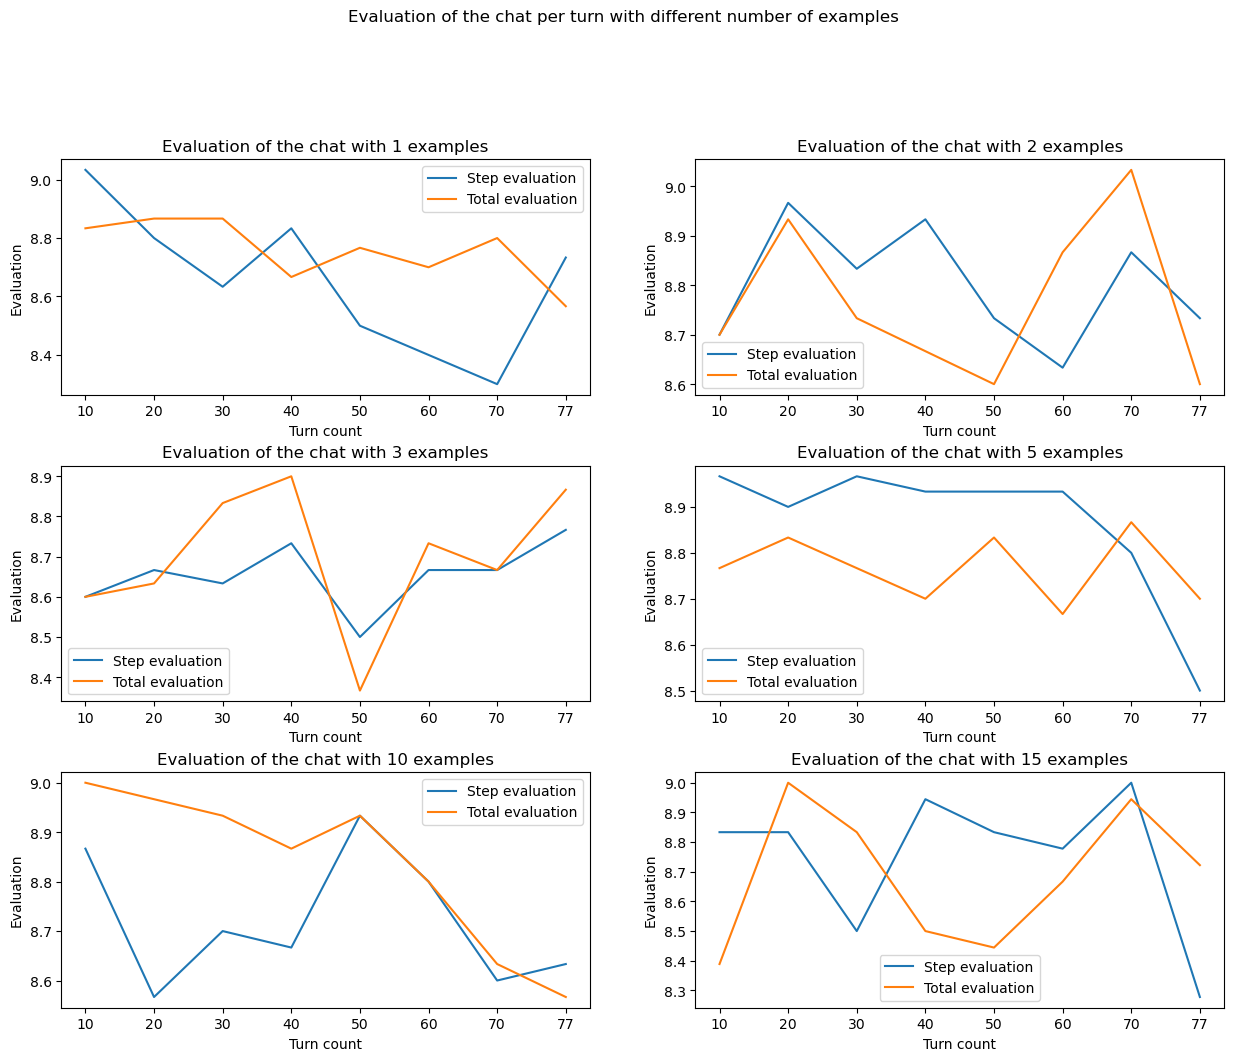

In [99]:
import matplotlib.pyplot as plt

# plot everything in subplots title with n_examples
fig, ax = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle("Evaluation of the chat per turn with different number of examples")

# order average evals by n_examples
average_evals = dict(sorted(average_evals.items()))
for i, key in enumerate(average_evals):
    ax = plt.subplot(4, 2, i + 1)
    ax.set_title(f"n_examples: {key}")

    step_eval = []
    total_eval = []

    for turn in average_evals[key]:
        step_eval.append((turn, average_evals[key][turn]["step_evaluation"]))
        total_eval.append((turn, average_evals[key][turn]["evaluation"]))

    ax.plot([x[0] for x in step_eval], [x[1] for x in step_eval], label="Step evaluation")
    ax.plot([x[0] for x in total_eval], [x[1] for x in total_eval], label="Total evaluation")
    ax.legend()
    ax.set_xlabel('Turn count')
    ax.set_ylabel('Evaluation')
    ax.set_title(f'Evaluation of the chat with {key} examples')

plt.subplots_adjust(hspace=0.3)  # Adjust the vertical spacing between subplots


In [58]:
chat_evals

{15: [{'10': {'evaluation': 8.333333333333334, 'step_evaluation': 9.0},
   '20': {'evaluation': 9.0, 'step_evaluation': 8.666666666666666},
   '30': {'evaluation': 8.666666666666666,
    'step_evaluation': 8.333333333333334},
   '40': {'evaluation': 8.0, 'step_evaluation': 9.0},
   '50': {'evaluation': 7.666666666666667, 'step_evaluation': 9.0},
   '60': {'evaluation': 8.666666666666666, 'step_evaluation': 9.0},
   '70': {'evaluation': 8.666666666666666,
    'step_evaluation': 8.666666666666666},
   '77': {'evaluation': 8.666666666666666, 'step_evaluation': 8.0}},
  {'10': {'evaluation': 7.666666666666667, 'step_evaluation': 9.0},
   '20': {'evaluation': 9.0, 'step_evaluation': 9.0},
   '30': {'evaluation': 9.333333333333334,
    'step_evaluation': 7.666666666666667},
   '40': {'evaluation': 8.0, 'step_evaluation': 9.0},
   '50': {'evaluation': 9.0, 'step_evaluation': 8.666666666666666},
   '60': {'evaluation': 8.666666666666666,
    'step_evaluation': 8.666666666666666},
   '70': {'ev